In [1]:
# import needed libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# libaries to be used for deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Libraries for modelling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [2]:
# load the data set 
df = pd.read_csv("spam.csv",encoding='latin-1')

# Remove Nan values
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1) 

# Rename columns 0 and 1
df = df.rename(columns={"v1":'label', "v2":'message'})  

# Show first 5 data
print(df.head())                                                  

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [3]:
# show summary of data

df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
# show duplicated entries within data

duplicatedRow = df[df.duplicated()]
print(duplicatedRow[:5])

    label                                            message
102   ham  As per your request 'Melle Melle (Oru Minnamin...
153   ham  As per your request 'Melle Melle (Oru Minnamin...
206   ham  As I entered my cabin my PA said, '' Happy B'd...
222   ham                             Sorry, I'll call later
325   ham                   No calls..messages..missed calls


In [5]:
# show data entry with most duplicates for ham and spam

df.groupby('label').describe().T

label                              ham  \
message count                     4825   
        unique                    4516   
        top     Sorry, I'll call later   
        freq                        30   

label                                                        spam  
message count                                                 747  
        unique                                                653  
        top     Please call our customer service representativ...  
        freq                                                    4

In [6]:
# Gather ham and spam emails 
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']

# Create numpy array for wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

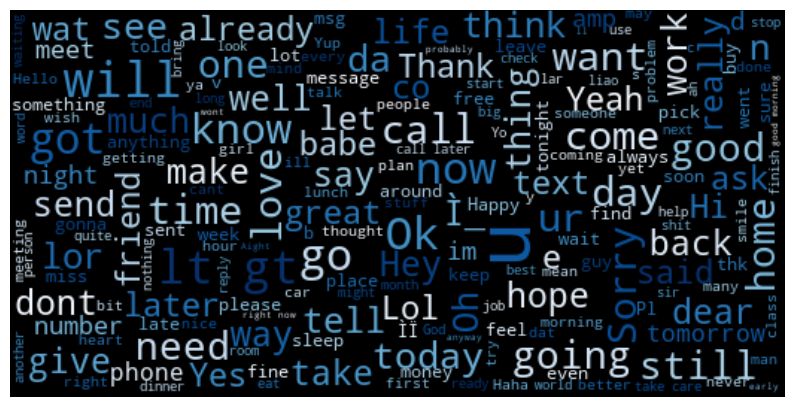

In [7]:
# visualize frequent words in ham messages

ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(10,8))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

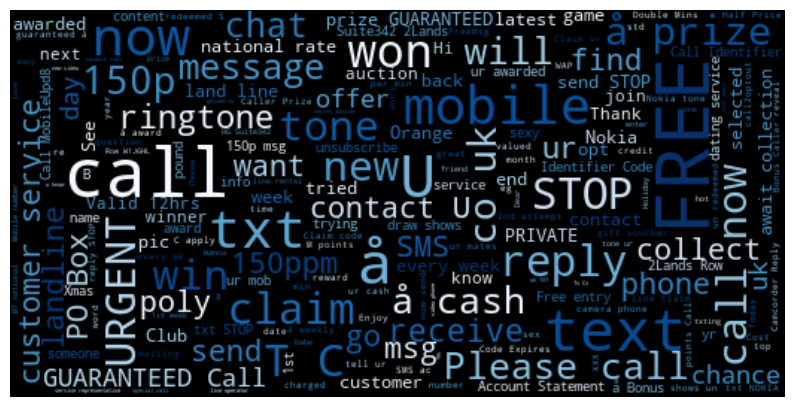

In [8]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(10,8))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

C:\Users\Ronan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

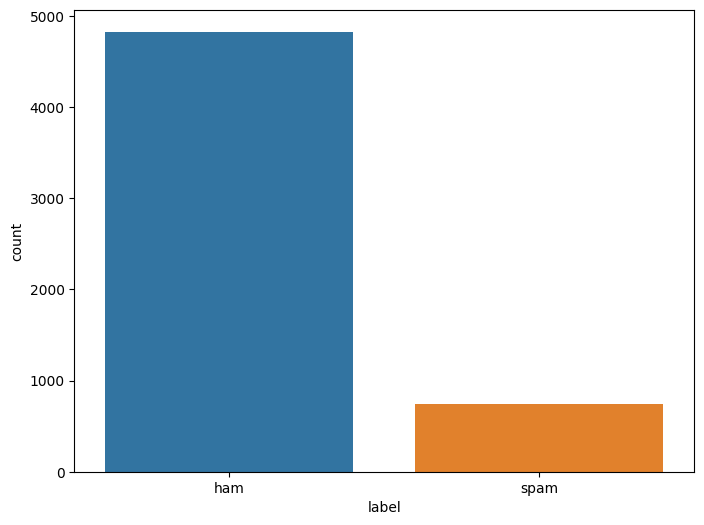

In [9]:
# Ham data far outnumbers spam data

plt.figure(figsize=(8,6))
sns.countplot(df.label)

In [10]:
# Ham data is downsampled to match spam data

ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


C:\Users\Ronan\AppData\Local\Temp\ipykernel_7600\3117451354.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
C:\Users\Ronan\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Message types')

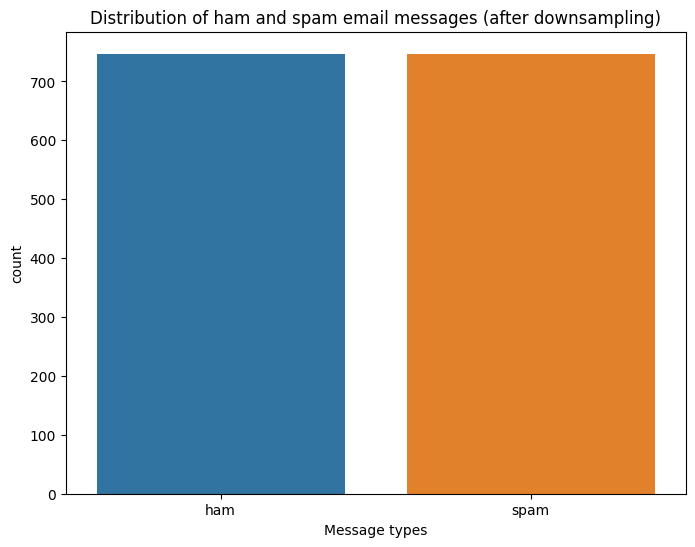

In [11]:
# Create a dataframe with these ham and spam msg

msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))

# show plot comparison of ham and spam 
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [12]:
# Show length and column for each text
msg_df['text_length'] = msg_df['message'].apply(len)

# Show average length 
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,69.626506
spam,138.866131


In [13]:
# Assign ham as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

# Split the data for training and testing
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [14]:
# List pre-processing hyperparameters

max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [15]:
# Tokenizer encodes words to integers

tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [16]:
# Show equivalent integer for each word

word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'now': 11,
 'is': 12,
 '2': 13,
 'and': 14,
 'free': 15,
 'in': 16,
 'or': 17,
 'have': 18,
 'on': 19,
 'ur': 20,
 'of': 21,
 'txt': 22,
 'with': 23,
 'are': 24,
 '4': 25,
 'from': 26,
 'me': 27,
 'text': 28,
 'get': 29,
 'stop': 30,
 'mobile': 31,
 'my': 32,
 'this': 33,
 'be': 34,
 'just': 35,
 'claim': 36,
 'only': 37,
 'it': 38,
 'reply': 39,
 'that': 40,
 'www': 41,
 'no': 42,
 'out': 43,
 'will': 44,
 'at': 45,
 'we': 46,
 'do': 47,
 'so': 48,
 'send': 49,
 'our': 50,
 'not': 51,
 'prize': 52,
 'new': 53,
 'if': 54,
 'cash': 55,
 'but': 56,
 'go': 57,
 'can': 58,
 '150p': 59,
 'up': 60,
 'uk': 61,
 "i'm": 62,
 'please': 63,
 'nokia': 64,
 'who': 65,
 'win': 66,
 't': 67,
 'won': 68,
 '1': 69,
 'all': 70,
 'tone': 71,
 'what': 72,
 'week': 73,
 'com': 74,
 'been': 75,
 'msg': 76,
 'want': 77,
 'phone': 78,
 'know': 79,
 '50': 80,
 'service': 81,
 'by': 82,
 'urgent': 83,
 '

In [17]:
# show how many unique tokens were produced

tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4054 unique tokens in training data. 


In [18]:
# Each sentence by is represented by sequences of numbers
# Each sequence have same length through padding
# Followed by training and testing of data

training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [19]:
# Shape of train tensor 
# Number of elements in each dimension

print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [20]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [21]:
print(training_padded[0])

[  1  37 200   8  31   1   3  24   1   2 241   2   7 148 264 127  31  10
  15   6   7  31 241  87  15  19   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [22]:
# Define hyper-parameters for dense spam model 

vocab_size = 500 
embeding_dim = 16
drop_value = 0.2 
n_dense = 24

In [23]:
# Architecture for Dense Model

model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [25]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [26]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6888 - accuracy: 0.6427 - val_loss: 0.6826 - val_accuracy: 0.8261 - 563ms/epoch - 15ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6687 - accuracy: 0.8469 - val_loss: 0.6512 - val_accuracy: 0.8462 - 53ms/epoch - 1ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6166 - accuracy: 0.8770 - val_loss: 0.5864 - val_accuracy: 0.8462 - 51ms/epoch - 1ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5329 - accuracy: 0.8895 - val_loss: 0.5006 - val_accuracy: 0.8528 - 54ms/epoch - 1ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4353 - accuracy: 0.8929 - val_loss: 0.4095 - val_accuracy: 0.8629 - 56ms/epoch - 1ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3531 - accuracy: 0.9004 - val_loss: 0.3376 - val_accuracy: 0.8896 - 51ms/epoch - 1ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2900 - accuracy: 0.9105 - val_loss: 0.2836 - val_accuracy: 0.9064 - 50ms/epoch - 1ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2450 - accuracy: 0.9197 - val_loss: 0.2430 - val_accuracy: 0.9130 - 53ms/epoch - 1ms/step
Epoch 9/30
38/38 - 0s 

In [27]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 779us/step - loss: 0.0933 - accuracy: 0.9632


[0.09326715022325516, 0.9632107019424438]

In [28]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)

# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

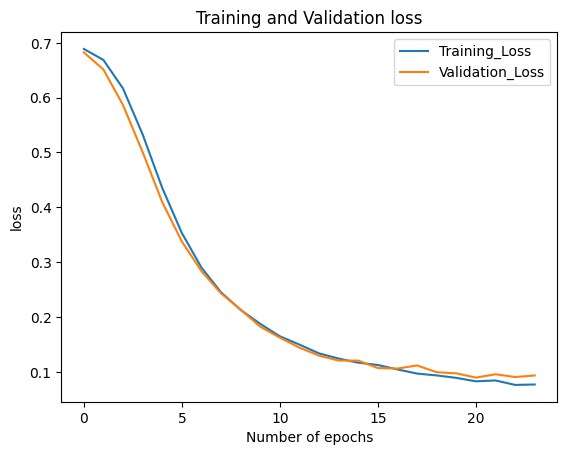

In [29]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

In [30]:
#load test data
df2 = pd.read_csv("output_spam.csv",encoding='latin-1')

# display long string 
df2[:20]

,ï»¿label,text
0,1,Feel Yourself That You Are Always Happy.. Slow...
1,2,staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323
2,3,Send me yetty's number pls.
3,4,Hey so this sat are we going for the intro pil...
4,5,I got it before the new year cos yetunde said ...
5,6,Hey we can go jazz power yoga hip hop kb and y...
6,7,Hey mate. Spoke to the mag people. Weâ°ÃÃ·re...
7,8,Morning only i can ok.
8,9,Wat time Ã_ finish?
9,10,Shant disturb u anymore... Jia you...


In [31]:
#Set variable for test data 
#convert column values to list

df3 = df2['text'].values.tolist()
predict_msg = df3

In [32]:
#use tokenizer for turning text to index

def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)     #predict test data entry

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)
print (predict_spam(predict_msg))

1/1 [==============================] - 0s 12ms/step
[[0.16921355]
 [0.12152459]
 [0.03274596]
 [0.05595115]
 [0.00220253]
 [0.02286066]
 [0.16355789]
 [0.00889771]
 [0.03045738]
 [0.0683258 ]
 [0.9992118 ]
 [0.9537044 ]
 [0.44290417]
 [0.99884516]
 [0.03054678]
 [0.02788048]
 [0.07231347]
 [0.19826442]
 [0.03342141]
 [0.00794093]]


In [33]:
X = (predict_spam(predict_msg))
prediction = pd.DataFrame(X, columns=['label']).to_csv('See_spam_output.csv')  #produce csv file for output of test data


1/1 [==============================] - 0s 13ms/step
